**Name:** Xian Jia Le,Ben

**EID:** 56214537

# CS5489 - Tutorial 5
## Predicting Bike Sharing Usage

In this tutorial you will train a regression function to predict the number people using bike sharing in each day.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
random.seed(100)
import pandas as pd
import xgboost as xgb
from scipy import stats

## Loading Data and Pre-processing
Next we need to load the data.  Download `Bike-Sharing-Dataset.zip`, and **unzip** it in the same directory as this ipynb file.  Then run the following cell to load the data.

In [2]:
# read the data
filename = 'Bike-Sharing-Dataset/day.csv'
df = pd.read_csv(filename)
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Here are the columns in the dataset. The last 3 columns are the counts for the day.

In [3]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Here is a description of the features:
- `instant`: record index
- `dteday`: date
- `season`: season (1: winter, 2:spring, 3:summer, 4:fall)
- `yr`: year (0: 2011, 1:2012)
- `mnth`: month (1=Jan to 12=Dec)
- `holiday`: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday`: day of the week (1=Sunday to 7=Saturday)
- `workingday`: if day is neither weekend nor holiday is 1, otherwise is 0.
- `weathersit`: weather situation
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp`: Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

The first two columns are the instance number and date, which aren't useful, so we will remove them.

In [4]:
# remove first 2 columns
df.drop(columns=['instant', 'dteday'], inplace=True)

Next we will examine the distribution of the features.

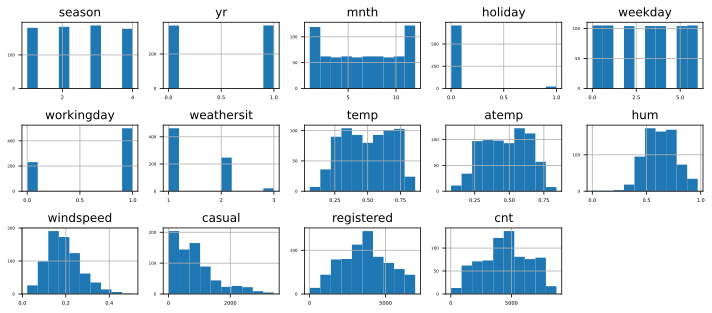

In [5]:
# show the feature distributions
foo = df.hist(layout=(14,5), figsize=(10,20), xlabelsize=5, ylabelsize=4)
plt.tight_layout()

And here are some simple statistics of the features.

In [6]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


You may notice that a few of the features are discrete values, such as `season`, `mnth`, `weekday`, and `weathersit`.  If we directly use the month feature, it may not make too much sense since adding/subtracting/multipllying 2 month numbers doesn't really mean anything related to the output. Instead, it is important which month it is.

Thus, we will convert these features into one-hot-encodings.  The original discrete features are removed, and the new features are appended to the end of the table.

In [7]:
# use pandas to create one-hot-encodings of a few colummns
dfd = pd.get_dummies(df, columns=['season', 'mnth', 'weekday', 'weathersit'])
dfd

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,0.344167,0.363625,0.805833,0.160446,331,654,985,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0.363478,0.353739,0.696087,0.248539,131,670,801,...,1,0,0,0,0,0,0,0,1,0
2,0,0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,...,0,1,0,0,0,0,0,1,0,0
3,0,0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,...,0,0,1,0,0,0,0,1,0,0
4,0,0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,0,1,0.254167,0.226642,0.652917,0.350133,247,1867,2114,...,0,0,0,0,1,0,0,0,1,0
727,1,0,1,0.253333,0.255046,0.590000,0.155471,644,2451,3095,...,0,0,0,0,0,1,0,0,1,0
728,1,0,0,0.253333,0.242400,0.752917,0.124383,159,1182,1341,...,0,0,0,0,0,0,1,0,1,0
729,1,0,0,0.255833,0.231700,0.483333,0.350754,364,1432,1796,...,1,0,0,0,0,0,0,1,0,0


Now we extract the data for running our regression algorithm. First we remove the counts to get the input features X.

In [8]:
# extract the features
dfX = dfd.drop(columns=['casual', 'registered', 'cnt'])
dataX = array(dfX)
dataX.shape

(731, 33)

In [9]:
# get the feature names
featnames = [x.strip() for x in dfX.columns]
print(featnames)

['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']


Next we use the total count as the target Y.

In [10]:
# get the target count
dataY = array(dfd['cnt'])
dataY.shape

(731,)

Finally, we extract the year number, which we will use for setting up the training/testing data later.

In [11]:
# get the year number (used for splitting the data into training/testing)
dataYear = array(dfd['yr'])
dataYear.shape

(731,)

Here is an example input/output for our problem.

In [12]:
print(featnames)

print("--- example features---")
print(dataX[0])
print("--- example target count")
print(dataY[0])

['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']
--- example features---
[0.       0.       0.       0.344167 0.363625 0.805833 0.160446 1.
 0.       0.       0.       1.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       1.       0.       1.
 0.      ]
--- example target count
985


Now we separate the data into training and testing sets.  Since our data is collected over time, it is better to separate the training and test data so that they don't overlap in time. This way, we can ensure that our method generalizes to newly collected data.

We will use the first year for training, and the second year for testing.

In [13]:
# use 1st year as training data
trainX = dataX[dataYear==0]
trainY = dataY[dataYear==0]
# use 2nd year as testing data
testX  = dataX[dataYear==1]
testY  = dataY[dataYear==1]

print(trainX.shape)
print(testX.shape)

(365, 33)
(366, 33)


Note that the input features are already normalized between 0 and 1 (or are binary values), so we don't need to perform feature normalization.

### Dummy regressor
We next test a "dummy" regressor that simply predicts the mean or median output value.  These are useful to evaluate the regression methods to see how much better they are than simply predicting the same value.

In [14]:
# dummy regressors that predict constant values
dummy_mean = dummy.DummyRegressor(strategy='mean')
dummy_mean.fit(trainX, trainY)
dummy_med  = dummy.DummyRegressor(strategy='median')
dummy_med.fit(trainX, trainY)

DummyRegressor(strategy='median')

Next we evaluate the regressor using MSE and MAE.

In [15]:
# function to evaluate root mean squared error (MSE) and mean absolute error (MAE)
def eval_predict(trueY, predY):
    MAE = metrics.mean_absolute_error(trueY, predY)
    RMSE = sqrt(metrics.mean_squared_error(trueY, predY))
    return RMSE, MAE

# function to make a scatter plot
def plot_scatter(testY, predY, titlestr):
    plt.scatter(testY, predY, s=1)
    plt.plot([min(testY),max(testY)], [min(testY),max(testY)], 'r-')
    plt.xlabel('true')
    plt.ylabel('prediction')
    r1,r2 = eval_predict(testY, predY)
    plt.title(titlestr + "\n(RMSE={:.3f}; MAE={:.3f})".format(r1,r2))
    plt.grid(True)

In [16]:
# place to store our regression results
trainerr={}; testerr={}

trainerr['dummy_mean'] = eval_predict(trainY, dummy_mean.predict(trainX))
testerr['dummy_mean']  = eval_predict(testY, dummy_mean.predict(testX))
trainerr['dummy_med']  = eval_predict(trainY, dummy_med.predict(trainX))
testerr['dummy_med']   = eval_predict(testY, dummy_med.predict(testX))

print("dummy-mean: train (RMSE,MAE)=", trainerr['dummy_mean'] )
print("dummy-mean: test  (RMSE,MAE)=", testerr['dummy_mean']  )
print("dummy-med:  train (RMSE,MAE)=", trainerr['dummy_med']  )
print("dummy-med:  test  (RMSE,MAE)=", testerr['dummy_med']   )

dummy-mean: train (RMSE,MAE)= (1376.8636667749531, 1197.7539801088385)
dummy-mean: test  (RMSE,MAE)= (2829.3083242385123, 2488.6733587843405)
dummy-med:  train (RMSE,MAE)= (1416.8517338156587, 1172.8849315068494)
dummy-med:  test  (RMSE,MAE)= (2578.749205425156, 2260.841530054645)


Finally, we can visualize the quality of the prediction result by using a scatter plot of truth vs. prediction.  Since we are using a "dummy" predictor, the x-value predictions are constant.  The red line shows the ideal regressor where all the predictions are equal to the true values.

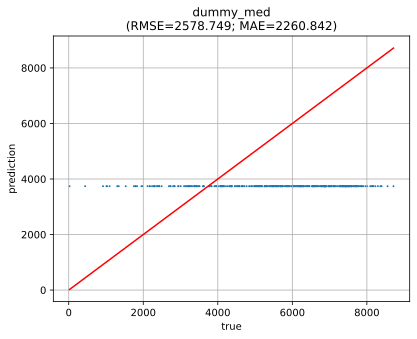

In [17]:
plot_scatter(testY, dummy_med.predict(testX), 'dummy_med')

## Prediction with Linear Regression

First we will look at predicting the count using simple linear regression models.  Use the training data to fit a linear model using Ordinary Least Squares and Ridge Regression.  Use cross-validation on the training set to select the optimal $\alpha$ parameter for ridge regression.

In [18]:
### INSERT YOUR CODE HERE

In [19]:
olsModel = linear_model.LinearRegression()

paramgrid={
}
ols=model_selection.GridSearchCV(olsModel,paramgrid,cv=5,n_jobs=-1,verbose=1)
ols.fit(trainX,trainY)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1, param_grid={},
             verbose=1)

In [20]:
rrModel=linear_model.Ridge()
paramgrid={
    "alpha":logspace(-3,6,20)
}
rr=model_selection.GridSearchCV(rrModel,paramgrid,cv=5,n_jobs=-1,verbose=1)
rr.fit(trainX,trainY)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 2.97635144e-03, 8.85866790e-03, 2.63665090e-02,
       7.84759970e-02, 2.33572147e-01, 6.95192796e-01, 2.06913808e+00,
       6.15848211e+00, 1.83298071e+01, 5.45559478e+01, 1.62377674e+02,
       4.83293024e+02, 1.43844989e+03, 4.28133240e+03, 1.27427499e+04,
       3.79269019e+04, 1.12883789e+05, 3.35981829e+05, 1.00000000e+06])},
             verbose=1)

Compare the two models using the RMSE and MAE between the predictions and the true values.  Below is  code that will calculate evaluation for the training and test sets.

In [21]:
# ols is the linear regression model
trainerr['ols'] = eval_predict(trainY, ols.predict(trainX))
testerr['ols']  = eval_predict(testY, ols.predict(testX))
print("OLS: train MSE,MAE =", trainerr['ols'])
print("OLS: test  MSE,MAE =", testerr['ols'])

# rr is the ridge regression model
trainerr['rr'] = eval_predict(trainY, rr.predict(trainX))
testerr['rr']  = eval_predict(testY, rr.predict(testX))
print("RR: train MSE,MAE =", trainerr['rr'])
print("RR: test  MSE,MAE =", testerr['rr'])

OLS: train MSE,MAE = (553.2710921147634, 415.4986301369863)
OLS: test  MSE,MAE = (2310.6294106204145, 2127.469945355191)
RR: train MSE,MAE = (550.2079445413241, 407.2785918688096)
RR: test  MSE,MAE = (2308.1211030944214, 2130.81935758155)


Which model has better prediction ability on the test set? Why?

The ridge regression model has better prediction as its' mse and mae score are lower than the scores from normal linear regression

Finally, we look at the scatter plot for ridge-regression.

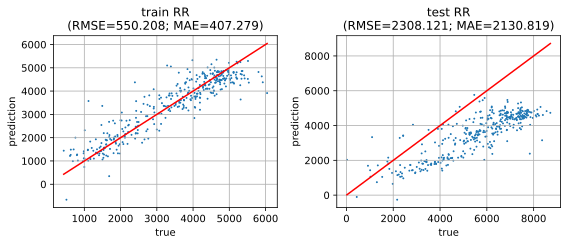

In [22]:
# rr is the ridge regression model
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, rr.predict(trainX), "train RR")
plt.subplot(1,2,2)
plot_scatter(testY, rr.predict(testX), "test RR")
plt.tight_layout()

Do you notice anything interesting about the test predictions?  We'll see how to solve this problem later.

The prediction points fit around the red line in training records while the points are offset from the line

# Which features are important?
Next we will investigate which features are the most important for the prediction.  Use LASSO with cross-validation to learn the model.

In [23]:
### INSERT YOUR CODE HERE

In [24]:
lasModel = linear_model.Lasso()
paramgrid={
    "alpha":logspace(-3,6,20)
}
las= model_selection.GridSearchCV(lasModel,paramgrid,cv=5,n_jobs=-1,verbose=1)
las.fit(trainX,trainY)
las=las.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Examine the LASSO coefficients by sorting them in descending order.

In [25]:
# las is the trained LASSO model
# sort coefficients from smallest to largest, then reverse it [::-1]
inds = argsort(abs(las.coef_))[::-1]
# print out
print("weight : feature description")
for i in inds:
    print("{: .3f} : {}".format(las.coef_[i], featnames[i]))
print("bias = ", las.intercept_)

weight : feature description
 2919.887 : temp
-1332.844 : weathersit_3
-1074.045 : season_1
 677.445 : mnth_5
-627.668 : windspeed
 556.689 : mnth_6
 428.079 : weathersit_1
-383.616 : hum
 368.463 : mnth_9
-307.283 : mnth_1
 306.956 : mnth_10
 230.759 : season_4
-192.717 : season_2
-145.492 : mnth_2
-122.775 : mnth_3
 81.596 : season_3
-73.060 : holiday
 51.279 : workingday
 50.019 : weekday_6
 23.309 : weekday_5
-10.241 : weekday_0
 3.123 : weekday_2
 0.000 : atemp
-0.000 : weekday_3
-0.000 : mnth_4
-0.000 : weekday_4
-0.000 : weathersit_2
-0.000 : mnth_7
 0.000 : mnth_8
-0.000 : mnth_11
-0.000 : mnth_12
-0.000 : weekday_1
 0.000 : yr
bias =  2223.006034705585


_Which features have largest affect on the predicted bike share count, and what is the interpretation?_

Note that the features are normalized between 0 and 1 (or are binary values), so the weights corresponding to increase/decrease of bike count.  The bias term corresponds to the typical number of bikes used, which is modified based on the features.

Temp has the largest affect on the prediction and it is positive linear interpretation

Now try feature selection using OMP.  You can try the top 10 features.

In [26]:
### INSERT YOUR CODE HERE

In [27]:
ompModel = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=22,normalize=False)
ompModel.fit(trainX,trainY)

inds = argsort(abs(ompModel.coef_))[::-1]
# print out
print("weight : feature description")
for i in inds:
    print("{: .3f} : {}".format(ompModel.coef_[i], featnames[i]))
print("bias = ", ompModel.intercept_)

weight : feature description
 3217.313 : temp
-2029.484 : windspeed
 1629.963 : weathersit_1
 1330.202 : weathersit_2
-1274.085 : hum
 1183.455 : mnth_5
 845.259 : mnth_6
 827.920 : season_4
 578.634 : mnth_9
 508.080 : season_3
 459.623 : mnth_4
-438.420 : season_1
 422.160 : mnth_10
-379.934 : mnth_1
-230.249 : holiday
-209.012 : mnth_2
 146.191 : mnth_8
 145.947 : weekday_6
 144.566 : workingday
-68.434 : weekday_4
-46.806 : weekday_1
-46.369 : weekday_3
 0.000 : atemp
 0.000 : season_2
 0.000 : weathersit_3
 0.000 : mnth_3
 0.000 : mnth_7
 0.000 : mnth_11
 0.000 : mnth_12
 0.000 : weekday_0
 0.000 : weekday_2
 0.000 : weekday_5
 0.000 : yr
bias =  1016.6086440569411


c:\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Do you get similar selected features? Why or why not?

No, there is not similar selected features becasuse the regulariztion is not the same

# Non-linear Regression
Now use non-linear regression to try to improve the prediction accuracy.  Use cross-validation on the training set to select the parameters. 

In [28]:
### INSERT YOUR CODE HERE

In [29]:
polyline = pipeline.Pipeline([
    ('polyfeats',preprocessing.PolynomialFeatures(degree=1)),
    ("linreg", linear_model.LinearRegression())
])

paramgrid={
    "polyfeats__degree":array([1,2,3,4])
}

plincv = model_selection.GridSearchCV(polyline,paramgrid,cv=5,n_jobs=-1,verbose=1)
plincv.fit(trainX,trainY)
bestr=plincv.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Make a scatter plot of the best regressor. Call it `bestr`.

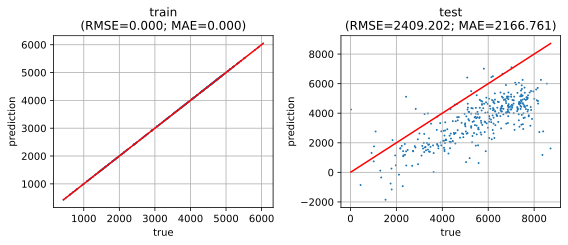

In [30]:
# scatter plot of the best regressor (bestr)
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, bestr.predict(trainX), "train")
plt.subplot(1,2,2)
plot_scatter(testY, bestr.predict(testX), "test")
plt.tight_layout()

_Which regression method performs the best? Why do you think so?_

Ridge regression performs the best since both rmse and mae score in test record of it are the lowest among the above method.

# Test set bias

In your scatter plot above, you may have noticed that the regressor is almost always under-predicting the count (the points are usually below the red line). This suggests that there is some bias in the test set.

Let's look at the plot of the count over time.  The left side is the training data (1st year), and the right side is the testing data (2nd year)

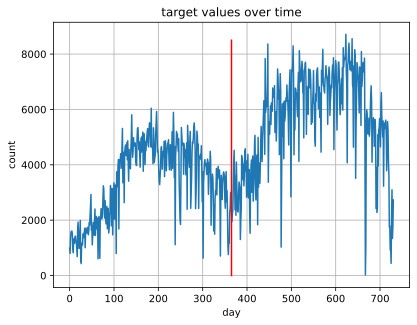

In [31]:
plt.plot(dataY)
plt.plot([365,365], [0,8500], 'r') # seperate first year and second year
plt.grid(True)
plt.xlabel('day')
plt.ylabel('count')
plt.title('target values over time');

Interestingly, it looks like bike sharing became more popular in the 2nd year, so the overall counts are higher (but the seasonal trend looks the same).

Let's assume that we noticed this upward trend in the first 3 months of the year, and collected the data for training.  We will then use the remaining part of the 2nd year for testing.

In [32]:
# get indices for month 1 to month 3
print(featnames[11], featnames[12], featnames[13])
inds = (testX[:,11].ravel()==1) + (testX[:,12].ravel()==1) + (testX[:,13].ravel()==1)

# new training data from 2nd year (months 1-3)
trainX2 = testX[inds]
trainY2  = testY[inds]
# new testing data from 2nd year (months 4-12)
testX2  = testX[logical_not(inds)]
testY2   = testY[logical_not(inds)]
print(trainX2.shape)
print(testX2.shape)

mnth_1 mnth_2 mnth_3
(91, 33)
(275, 33)


There are several approaches for using the new data:
1. use the new data to train the regressor, and ignore the old data.
2. append the new data with the old data and train a regressor.  Note that we kept the "year" feature, so the regressor can distinguish the new and old training data.
3. use the new data to train a regressor on the residual error of the old regressor.  The residual error is the difference between the predicted count and true count on the new training data.

Using **one selected** regression method, try each of the approaches above to use the new data. You should compare the 3 approaches with the regressor trained on the original data and tested on the new test set (`testY2`).

In [33]:
# append new data with old data
trainY2_append = concatenate((trainY, trainY2), axis=0)
trainX2_append = concatenate((trainX, trainX2), axis=0)
print(trainY2_append.shape)
print(trainX2_append.shape)

(456,)
(456, 33)


In [34]:
### INSERT YOUR CODE HERE

Fitting 5 folds for each of 20 candidates, totalling 100 fits


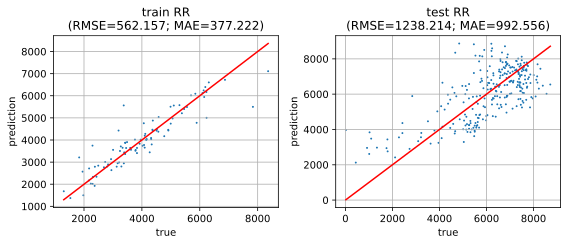

In [35]:
# method 1 only new data
rrModel1=linear_model.Ridge()
paramgrid={
    "alpha":logspace(-3,6,20)
}
rr1=model_selection.GridSearchCV(rrModel1,paramgrid,cv=5,n_jobs=-1,verbose=1)
rr1.fit(trainX2,trainY2)

plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY2, rr1.predict(trainX2), "train RR")
plt.subplot(1,2,2)
plot_scatter(testY2, rr1.predict(testX2), "test RR")
plt.tight_layout()

Fitting 5 folds for each of 20 candidates, totalling 100 fits


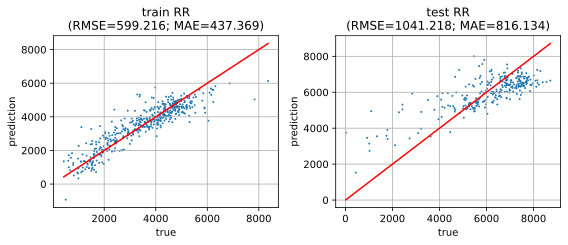

In [36]:
# method 2 new data + old data
rrModel2=linear_model.Ridge()
paramgrid={
    "alpha":logspace(-3,6,20)
}
rr2=model_selection.GridSearchCV(rrModel2,paramgrid,cv=5,n_jobs=-1,verbose=1)
rr2.fit(trainX2_append,trainY2_append)

plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY2_append, rr2.predict(trainX2_append), "train RR")
plt.subplot(1,2,2)
plot_scatter(testY2, rr2.predict(testX2), "test RR")
plt.tight_layout()

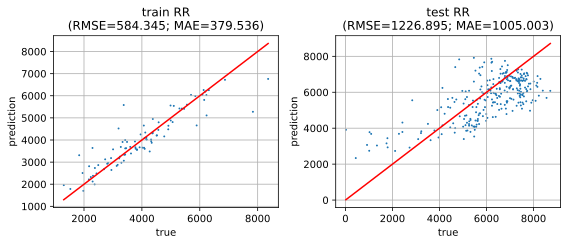

In [37]:
# method 3 new data with old model

rr = rr.best_estimator_
rr.fit(trainX2,trainY2)
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY2, rr.predict(trainX2), "train RR")
plt.subplot(1,2,2)
plot_scatter(testY2, rr.predict(testX2), "test RR")
plt.tight_layout()

_Which approach for using the new data is better? Explain why you think the other approaches don't work well._

The second approach is better as both rmse and mae are lowest. Method 1 does not work well as it only considers the new data and lack of old which will not give a good generaliztion. Method 3 does not work well because the amount of new data is smaller than the old data and causes the regressor hard to correct the weights. 